In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
from src import model, preprocessor, pose_mask_generation


In [2]:
print("Loading model")
diffusion_model = model.Model("C:/Users/kevmo/Documents/ai_prototyping/auth.json")

Loading model


Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 1363.71it/s]


In [12]:
# Give me a ...
prompt = "a pair of pink pants"
#path_prefix = "C:/Users/kevmo/Documents/ai_prototyping/text2img"
#IMAGE_PATH = f'{path_prefix}/sample_images/side_poser.png'
#IMAGE_PATH = f'{path_prefix}/sample_images/brandon-atchison-eexdeq3NleQ-unsplash.jpg'
#IMAGE_PATH = f'{path_prefix}/sample_images/christian-buehner-vbdil5l6AZE-unsplash.jpg'
#IMAGE_PATH = f'{path_prefix}/sample_images/stephanie-liverani-Zz5LQe-VSMY-unsplash.jpg'
#IMAGE_PATH = f'{path_prefix}/sample_images/elijah-m-henderson-jRA-yoDL68M-unsplash.jpg'
#IMAGE_PATH = f'{path_prefix}/sample_images/cliff_woman.jpg'
#IMAGE_PATH = f'{path_prefix}/sample_images/standing_woman.jpg'
IMAGE_PATH = "C:/Users/kevmo/Downloads/sonnie-hiles-gG70fyu3qsg-unsplash.jpg"
#IMAGE_PATH = "inpainted_sample.png"

Run the main algorithm routines

load image + preprocess


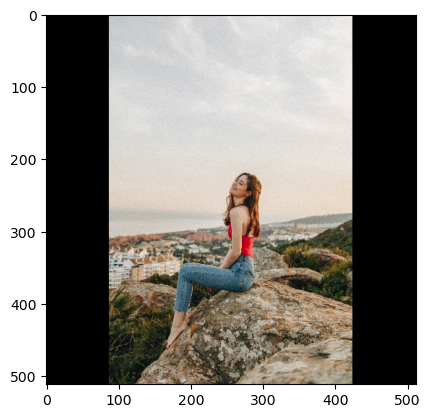

generating pose mask
Blob type identified: bottom_half


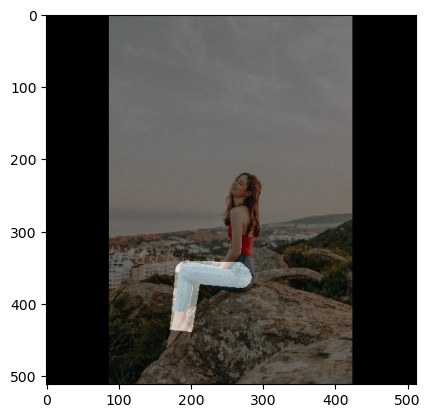

generate inpainting result
(512, 512, 3) 255


100%|██████████| 100/100 [00:10<00:00,  9.24it/s]


post-processing
save result to disk


Text(0.5, 1.0, 'Give me a pair of pink pants')

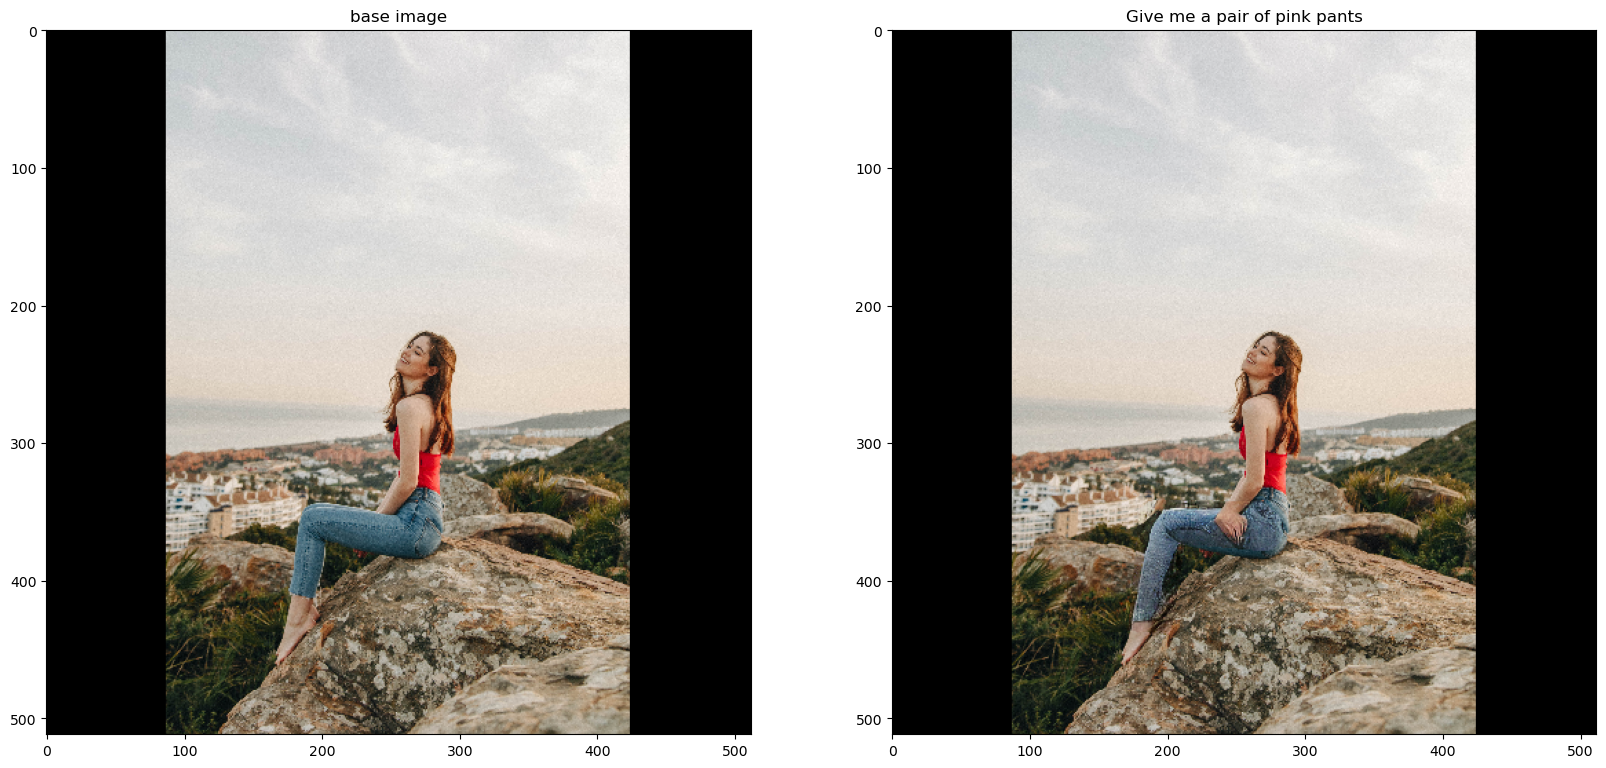

In [13]:
print("load image + preprocess")
primary_image_arr = preprocessor.process_input(image_path=IMAGE_PATH)
primary_image_arr = preprocessor.preprocessing(primary_image_arr)
plt.imshow(primary_image_arr)
plt.show()

print("generating pose mask")
mask_image_arr, blob_type = pose_mask_generation.translate_prompt_to_body_blob(primary_image_arr, prompt)
print("Blob type identified:", blob_type)
plt.figure()
plt.imshow(primary_image_arr)
plt.imshow(mask_image_arr, cmap='jet', alpha=0.5)
plt.show()

print("generate inpainting result")
base_input_image = Image.fromarray(primary_image_arr)
print(mask_image_arr.shape, mask_image_arr.max())
mask_input_image = Image.fromarray(mask_image_arr)
output_image: Image = diffusion_model.infer(prompt=prompt, base_image=base_input_image, mask_image=mask_input_image)

print("post-processing")
output_image = preprocessor.restore_mask(
        output_image,
        np.asarray(base_input_image),
        np.asarray(mask_input_image)
)

print("save result to disk")
output_image.save("./inpainted_sample.png")
mask_input_image.save("./inpainted_sample_mask.png")

fig, ax = plt.subplots(1,2, figsize=(20,12))
ax[0].imshow(primary_image_arr)
ax[0].set_title("base image")
ax[1].imshow(output_image)
ax[1].set_title("Give me " + prompt)


In [ ]:
processed_output_img = np.asarray(output_image) * (np.asarray(mask_input_image) / 255) + np.asarray(base_input_image) * (1 - np.asarray(mask_input_image) / 255)



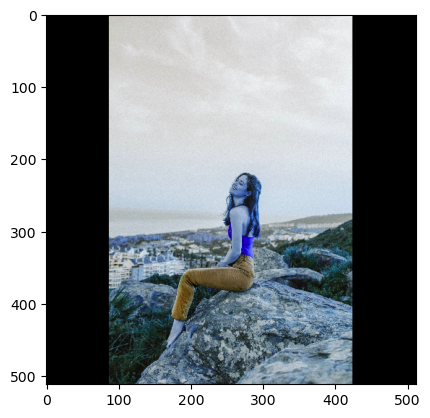

In [ ]:
#plt.imshow(output_image)
plt.imshow(Image.fromarray(processed_output_img.astype(np.uint8)))

In [ ]:
(np.asarray(output_image) * (np.asarray(mask_input_image) / 255)).max()

251.0

In [ ]:
(np.asarray(mask_input_image) / 255).max()

1.0